# DPO loss 

In [ ]:



from datasets import load_dataset, DatasetDict
import torch
import os

# dataset_name = "princeton-nlp/mistral-instruct-ultrafeedback"
dataset_name = "princeton-nlp/llama3-ultrafeedback-armorm"

train_dataset = load_dataset(dataset_name)['train']
test_dataset = load_dataset(dataset_name)['test']



dpo_losses = torch.load(f"dpo_losses_{os.path.basename(dataset_name)}.pt")
dpo_losses = [t.item() for t in dpo_losses]

train_dataset = train_dataset.add_column('dpo_loss', dpo_losses)




sorted_train_dataset = train_dataset.sort(f"dpo_loss", reverse=False)

sorted_train_dataset = sorted_train_dataset.remove_columns([column_name for column_name in sorted_train_dataset.column_names if column_name not in test_dataset.column_names ])

final_dataset = DatasetDict({
    'train': sorted_train_dataset,
    'test': load_dataset(dataset_name)['test']
})


# final_dataset.push_to_hub(f"jlpang888/{os.path.basename(dataset_name)}_sorted_dpo_loss")
final_dataset.save_to_disk(f"datasets/{os.path.basename(dataset_name)}_sorted_dpo_loss")

# final_dataset.push_to_hub(f"jlpang888/{os.path.basename(dataset_name)}_sorted_rating_score")



Saving the dataset (1/1 shards): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1961/1961 [00:00<00:00, 2711.21 examples/s]


## DPO loss sorting

In [ ]:
from datasets import load_dataset, DatasetDict
import torch
import os

dataset_name = "princeton-nlp/mistral-instruct-ultrafeedback"
# dataset_name = "princeton-nlp/llama3-ultrafeedback-armorm"

train_dataset = load_dataset(dataset_name)['train']
test_dataset = load_dataset(dataset_name)['test']



dpo_losses = torch.load(f"dpo_losses_{os.path.basename(dataset_name)}.pt")
dpo_losses = [t.item() for t in dpo_losses]


train_dataset = train_dataset.add_column('score_chosen', dpo_losses)
train_dataset = train_dataset.add_column('score_rejected', [0.] * len(train_dataset))


test_dataset = test_dataset.add_column('score_chosen', [1.] * len(test_dataset) )
test_dataset = test_dataset.add_column('score_rejected', [0.] * len(test_dataset) )


sorted_train_dataset = train_dataset.sort(f"score_chosen", reverse=False)

sorted_train_dataset = sorted_train_dataset.remove_columns([column_name for column_name in sorted_train_dataset.column_names if column_name not in test_dataset.column_names ])

final_dataset = DatasetDict({
    'train': sorted_train_dataset,
    'test': test_dataset
})


final_dataset.push_to_hub(f"jlpang888/{os.path.basename(dataset_name)}_sorted_dpo_loss")
# final_dataset.save_to_disk(f"datasets/{os.path.basename(dataset_name)}_sorted_dpo_loss")

# final_dataset.push_to_hub(f"jlpang888/{os.path.basename(dataset_name)}_sorted_rating_score")

print(f"target dpo loss: {sorted_train_dataset[int(0.9 * len(sorted_train_dataset))]['score_chosen']}")

Uploading the dataset shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/ shards]


target dpo loss: 9.1875


: 

## Rating Score

In [ ]:
from datasets import load_dataset, DatasetDict
import torch
import os
from collections import Counter

root_data_path = "/home/azureuser/cloudfiles/code/Users/jinlong.pang/DS2"


# dataset_name = "princeton-nlp/mistral-instruct-ultrafeedback"
dataset_name = "princeton-nlp/llama3-ultrafeedback-armorm"



train_dataset = load_dataset(dataset_name)['train']
test_dataset = load_dataset(dataset_name)['test']


tot_scores_all = {}
for response_tag in ['chosen', 'rejected']:
    if 'mistral' in dataset_name:
        path_file = f"{root_data_path}/scoring_outputgpt-4o-mini/mistral-ultrafeedback/{response_tag}"
    else:
        path_file = f"{root_data_path}/scoring_outputgpt-4o-mini/llama3-ultrafeedback/{response_tag}"

    file_names = os.listdir(path_file)
    existing_index = [f for f in file_names if 'output_scores_' in f]

    tot_scores = []
    for idx in range(len(existing_index)):
        file_path = os.path.join(path_file, f"output_scores_{idx}.pt")
        if os.path.exists(file_path):
            batch_scores = torch.load(file_path)
            tot_scores.extend(batch_scores)

    # 替换 None 为 0
    tot_scores = [-10 if score is None or score == 0 else score for score in tot_scores]
    tot_scores_all[response_tag] = tot_scores

    print(f"[{response_tag}] Score count: {Counter(tot_scores)}")



# 计算分数差

score_diff = [c - r for c, r in zip(tot_scores_all['chosen'], tot_scores_all['rejected'])]
 

train_dataset = train_dataset.add_column('score_chosen', tot_scores_all['chosen'])
train_dataset = train_dataset.add_column('score_rejected', tot_scores_all['rejected'])
train_dataset = train_dataset.add_column('score_diff', score_diff)

test_dataset = test_dataset.add_column('score_chosen', [int(1)] * len(test_dataset) )
test_dataset = test_dataset.add_column('score_rejected', [int(0)] * len(test_dataset) )

sorted_train_dataset = train_dataset.sort(f"score_diff", reverse=True)

sorted_train_dataset = sorted_train_dataset.remove_columns([column_name for column_name in sorted_train_dataset.column_names if column_name not in test_dataset.column_names ])

final_dataset = DatasetDict({
    'train': sorted_train_dataset,
    'test': test_dataset
})


final_dataset.push_to_hub(f"jlpang888/{os.path.basename(dataset_name)}_sorted_rating_score")

print(f"dataset name: jlpang888/{os.path.basename(dataset_name)}_sorted_rating_score")


/anaconda/envs/qualtydpo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

[chosen] Score count: Counter({7: 21141, 6: 15246, 8: 14517, 5: 4322, -10: 3104, 4: 944, 9: 404, 3: 165, 2: 27, 1: 6})
[rejected] Score count: Counter({7: 21736, 6: 15334, 8: 13335, 5: 4536, -10: 3502, 4: 963, 9: 275, 3: 159, 2: 31, 1: 5})


Uploading the dataset shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08 shards/s]


dataset name: jlpang888/llama3-ultrafeedback-armorm_sorted_rating_score


## Original Reward Score

In [ ]:



from datasets import load_dataset, DatasetDict
import torch
import os

dataset_name = "princeton-nlp/mistral-instruct-ultrafeedback"
# dataset_name = "princeton-nlp/llama3-ultrafeedback-armorm"

train_dataset = load_dataset(dataset_name)['train']
test_dataset = load_dataset(dataset_name)['test']


score_chosen = []
score_rejected = []
for sample in train_dataset:
    chosen_repsonse = sample['chosen'][-1]['content']
    rejected_repsonse = sample['rejected'][-1]['content']

    chosen_rm_score = None 
    rejected_rm_score = None
    missing_sample_idx = []
    for idx, response in enumerate(sample['all_generated_responses']):
        if response == chosen_repsonse:
            chosen_rm_score = sample['all_rm_scores'][idx]
        if response == rejected_repsonse:
            rejected_rm_score = sample['all_rm_scores'][idx]
            
    if chosen_rm_score is None or rejected_rm_score is None:
        missing_sample_idx.append(idx)
        # print(f"not match response: {idx}")
    score_chosen.append(chosen_rm_score)
    score_rejected.append(rejected_rm_score)


score_diff = [c - r for c, r in zip(score_chosen, score_rejected)]

train_dataset = train_dataset.add_column('score_chosen', score_chosen)
train_dataset = train_dataset.add_column('score_rejected', score_rejected)
train_dataset = train_dataset.add_column('score_diff', score_diff)


sorted_train_dataset = train_dataset.sort(f"score_diff", reverse=True)

test_dataset = test_dataset.add_column('score_chosen', [float(1)] * len(test_dataset) )
test_dataset = test_dataset.add_column('score_rejected', [float(0)] * len(test_dataset) )


sorted_train_dataset = sorted_train_dataset.remove_columns([column_name for column_name in sorted_train_dataset.column_names if column_name not in test_dataset.column_names ])

final_dataset = DatasetDict({
    'train': sorted_train_dataset,
    'test': test_dataset
})



final_dataset.push_to_hub(f"jlpang888/{os.path.basename(dataset_name)}_sorted_rm_score")


print(f"jlpang888/{os.path.basename(dataset_name)}_sorted_rm_score")


In [29]:
train_dataset[1]

{'prompt_id': 'ec39d34c20179b2d585bf5c1f42a78152187e3f08f06df8a58b51d78e07c0d06',
 'prompt': 'Summorize the movie Beer from 1985',
 'chosen': [{'content': 'Summorize the movie Beer from 1985', 'role': 'user'},
  {'content': '"Beer," also known as "Three Wishes" or "Der Dritte Wunsch" in its original German title, is a 1985 West German comedy film directed by Hannes Sturm. The movie tells the story of a man named Ludwig (Heinz Bennent), a hardworking and responsible family man who leads a monotonous life. One day, while working at his brewery, he discovers a magical barrel of beer that grants three wishes to whoever drinks from it.\n\nLudwig, frustrated with his mundane existence, makes his first wish for wealth, which brings him instant financial success. However, he soon realizes that money brings its own problems and he misses the simple joys of his old life. For his second wish, he asks for love and finds himself courted by numerous women. But he eventually realizes that true love c

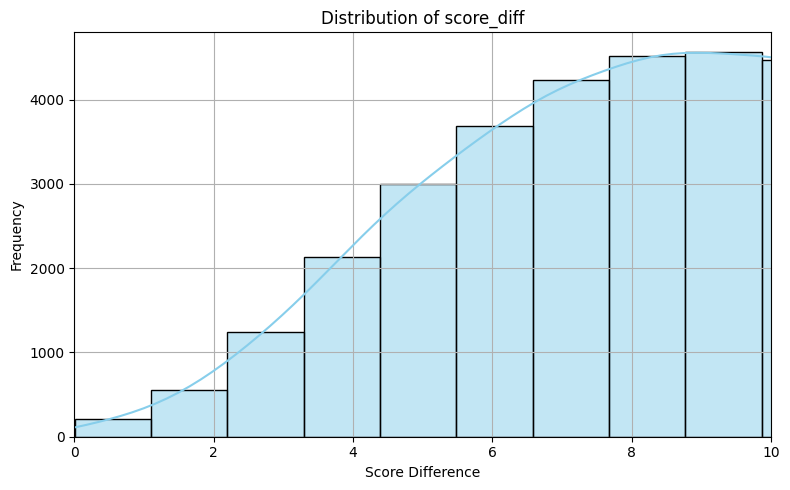

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 score_diff 是一个列表或 Pandas Series
# 示例数据
# score_diff = [1.2, -0.3, 0.8, 2.5, -1.0, 0.4, ...]

plt.figure(figsize=(8, 5))
sns.histplot(score_diff, kde=True, bins=30, color='skyblue')
plt.title("Distribution of score_diff")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")
plt.xlim(0,  10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
target_sample = sorted_train_dataset[int(0.9 * (len(sorted_train_dataset)))]


target_score_diff = target_sample['score_chosen'] - target_sample['score_rejected']
target_score_diff

5.078502893447876

In [16]:
sum(score_diff)

0.0

In [2]:
from datasets import load_dataset, concatenate_datasets, DatasetDict


train_dataset = load_dataset("jlpang888/ultrafeedback_sorted_score_diff")['train']

test_dataset = load_dataset("jlpang888/ultrafeedback_sorted_score_diff")['test']



# 计算分界点
n_total = len(train_dataset)
n_80 = int(n_total * 0.8)
n_90 = int(n_total * 0.9)

# 切片
first_80 = train_dataset.select(range(0, n_80))
slice_80_90 = train_dataset.select(range(n_80, n_90))
slice_90_100 = train_dataset.select(range(n_90, n_total))

# 对调这两部分
swapped_tail = concatenate_datasets([slice_90_100, slice_80_90])

# 组合成新的 train 数据集
new_train_dataset = concatenate_datasets([first_80, swapped_tail])



final_dataset = DatasetDict({
    'train': new_train_dataset,
    'test': test_dataset
})

final_dataset.push_to_hub(f"jlpang888/ultrafeedback_sorted_score_diff_10perc_swap")



Uploading the dataset shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22 shards/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_score_diff_10perc_swap/commit/6b412eebd7423c6a56e6aeb9cc1b77cfd33c1b74', commit_message='Upload dataset', commit_description='', oid='6b412eebd7423c6a56e6aeb9cc1b77cfd33c1b74', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

# 加载数据集
dataset = load_dataset("jlpang888/ultrafeedback_sorted_score_diff")
train_dataset = dataset['train']
test_dataset = dataset['test']

# 计算分界点
n_total = len(train_dataset)
n_85 = int(n_total * 0.85)
n_90 = int(n_total * 0.90)
n_95 = int(n_total * 0.95)

# 切片
first_85 = train_dataset.select(range(0, n_85))
slice_85_90 = train_dataset.select(range(n_85, n_90))
slice_90_95 = train_dataset.select(range(n_90, n_95))
rest_95_100 = train_dataset.select(range(n_95, n_total))

# 对调两段：85-90 和 90-95
swapped_middle = concatenate_datasets([slice_90_95, slice_85_90])

# 拼接：0-85 + (90-95, 85-90) + 95-100
new_train_dataset = concatenate_datasets([first_85, swapped_middle, rest_95_100])

# 构造新的 DatasetDict 并上传
final_dataset = DatasetDict({
    'train': new_train_dataset,
    'test': test_dataset
})

final_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_score_diff_5perc_swap")
